# Open Exploration using the MORO Policies

## 1. Introduction

The nine (9) policies which were found on the pareto front in [notebook 3](LINK) are evaluated through open exploration. 

In [1]:
# Import every package we need

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


In [2]:
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)

from ema_workbench import (
    Model, MultiprocessingEvaluator, Policy, Scenario, SequentialEvaluator)

from ema_workbench.em_framework.evaluators import perform_experiments, optimize
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.analysis import parcoords, feature_scoring
from ema_workbench.util import ema_logging, utilities
from ema_workbench.analysis.feature_scoring import get_feature_scores_all, RuleInductionType

ema_logging.log_to_stderr(ema_logging.INFO)


/usr/local/lib/python3.7/site-packages/ema_workbench/analysis/prim.py:31: ImportWarning: altair based interactive inspection not available
  "inspection not available"), ImportWarning)
/usr/local/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


<Logger EMA (DEBUG)>

In [3]:
# Load in self-created visualization functions
from visualization_functions import histogram_maker, mean_outcomes, aggregate_outcomes, scatter_maker, pairplot_maker, boxplot_histogram_maker, boxplot_maker


In [4]:
# Initialize model parameters
# from model.dike_model_function import DikeNetwork  # @UnresolvedImport
# from model.problem_formulation import get_model_for_problem_formulation

# dike_model, planning_steps = get_model_for_problem_formulation(5)

# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.perform_experiments(scenarios=50,policies=policies)

# from ema_workbench.util.utilities import (save_results, load_results)

# save_results(results, "Outcomes/MOROpolicies50Scenarios.csv" )


In [5]:
import pickle

results_MORO, convergence = pickle.load(
    open('Outcomes/MORO_s50_nfe20000.pkl', 'rb'))
results_MORO.head()


,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Damage Score,Deaths Score,Dike Invest Score,RfR Invest Score,Evac Score
0,0,0,0,0,0,0,1,1,1,0,...,3,2,2,1,1,1.964370e+14,1.861056e-06,1.196531e+18,1.178112e+16,3.252648e+08
1,1,1,0,0,0,0,1,1,1,0,...,3,2,2,1,1,1.133849e+11,1.143893e-07,1.196531e+18,9.305655e+18,0.000000e+00
2,0,0,1,0,0,0,1,1,1,0,...,3,2,2,1,1,7.853715e+11,9.160793e-08,1.196531e+18,6.272040e+18,1.574746e+06
3,0,0,0,0,0,0,1,1,1,0,...,3,2,2,1,1,1.964370e+14,1.292400e-04,1.196531e+18,1.178112e+16,0.000000e+00
4,0,0,0,0,0,0,0,1,1,0,...,3,2,2,1,1,1.980599e+14,1.307336e-04,1.196531e+18,7.906444e+17,0.000000e+00


In [6]:
policies = []
for row in range(results_MORO.shape[0]):
    policies.append(
        # Do not include the damage scores
        Policy(name=row, **results_MORO.iloc[row, :-5].to_dict())
    )


In [7]:
from ema_workbench.util.utilities import (save_results, load_results)

results = load_results('Outcomes/MOROpolicies400Scenarios.csv')

experiments, outcomes = results
outcomes = pd.DataFrame(outcomes)
experiments = pd.DataFrame(experiments)
results = experiments.join(outcomes)
results = results.drop(columns="model")
results.head()


[MainProcess/INFO] results loaded succesfully from /Users/jrwang/Documents/Coding/Model-based-decision-making/Outcomes/MOROpolicies400Scenarios.csv


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_Dike Investment Costs 2,A.3_Expected Number of Deaths 2,A.4_Expected Annual Damage 2,A.4_Dike Investment Costs 2,A.4_Expected Number of Deaths 2,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2
0,16.0,95.366886,1.0,0.334887,278.890461,10.0,0.602767,173.139661,1.5,0.364909,...,5.639157e+07,0.0,0.0,5.585544e+07,0.0,0.0,6.071198e+07,0.0,30700000.0,0.0
1,20.0,311.236496,1.5,0.648404,102.259704,1.0,0.888705,84.422554,1.5,0.359334,...,5.639157e+07,0.0,0.0,5.585544e+07,0.0,0.0,6.071198e+07,0.0,30700000.0,0.0
2,102.0,300.059210,1.0,0.449451,111.094021,1.5,0.935721,208.285945,10.0,0.006956,...,5.639157e+07,0.0,0.0,5.585544e+07,0.0,0.0,6.071198e+07,0.0,30700000.0,0.0
3,69.0,128.702886,10.0,0.595469,119.355882,1.0,0.872678,146.418145,1.0,0.685500,...,5.639157e+07,0.0,0.0,5.585544e+07,0.0,0.0,6.071198e+07,0.0,30700000.0,0.0
4,44.0,278.386091,10.0,0.190867,149.400545,1.0,0.153690,335.927277,1.5,0.905726,...,5.639157e+07,0.0,0.0,5.585544e+07,0.0,0.0,6.071198e+07,0.0,30700000.0,0.0


In [8]:
aggregate_outcomes(results, "Expected Annual Damage")
aggregate_outcomes(results, "Expected Number of Deaths")


## 2. Data visualization

Visual examination on the data to have a better understanding of what is happening in the model.

### 2.1 Histogram plots

A distribution of the outcomes over location and timesteps are given. These histograms only showcase the expected annual damages and the expected number of deaths.

#### 2.1.1 Expected Number of Deaths

Plot Expected Number of Deaths(Histogram)
This is timestep 0


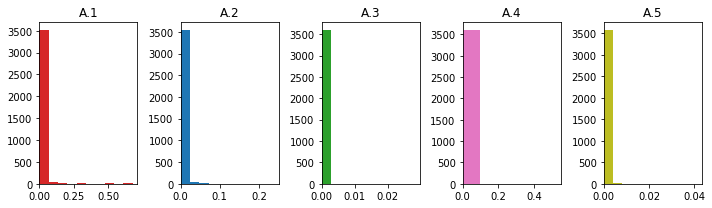

This is timestep 1


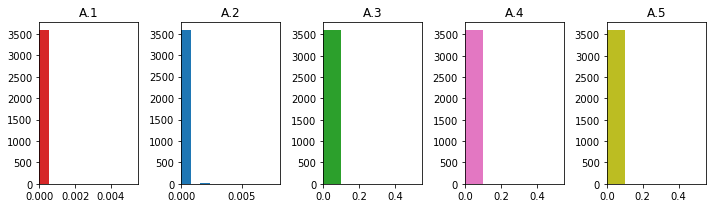

This is timestep 2


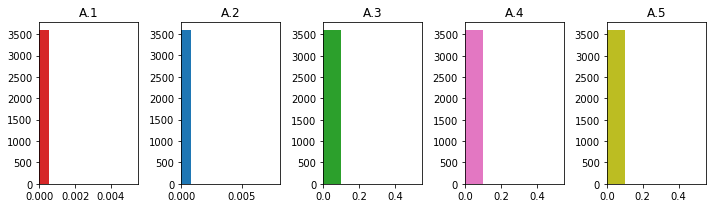

In [9]:
histogram_maker(results, "Expected Number of Deaths")


#### 2.1.2 Expected Annual Damage

Plot Expected Annual Damage(Histogram)
This is timestep 0


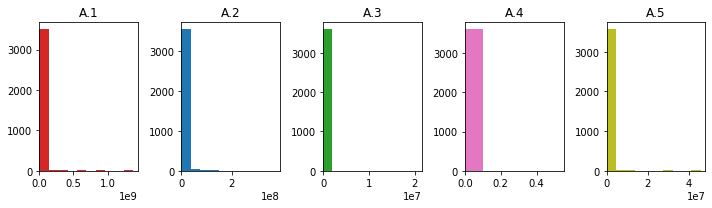

This is timestep 1


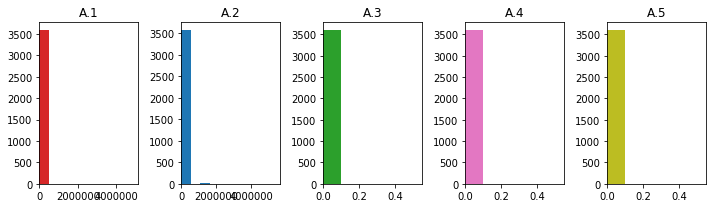

This is timestep 2


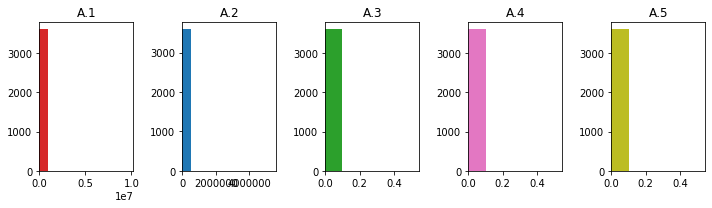

In [10]:
histogram_maker(results, "Expected Annual Damage")


The histograms look very promising, as the ranges of deaths and damages over the locations are very low. Locations A.1 and A.2 in the first timestep however includes scenarios where the damages and deaths can be high. 

### 2.2 Mean outcomes

No handles with labels found to put in legend.
No handles with labels found to put in legend.


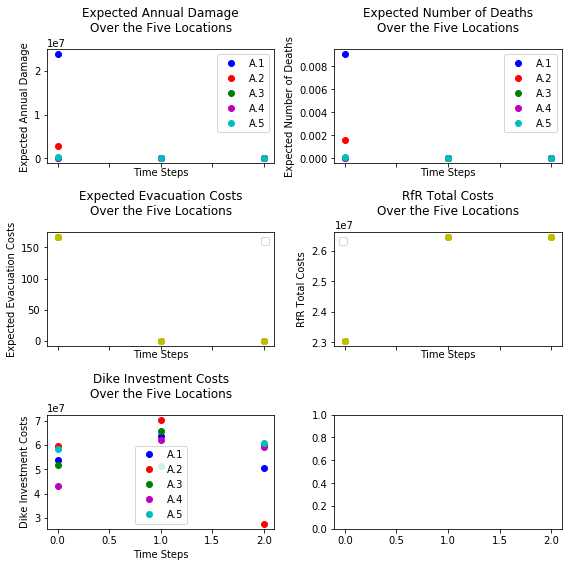

In [11]:
# Select the outcomes you want the mean, for base case the costs are not very interesting.
outcome_names = ["Expected Annual Damage", "Expected Number of Deaths",
                 "Expected Evacuation Costs", "RfR Total Costs", "Dike Investment Costs"]

mean_outcomes(results, outcome_names)


The means graphs show the same conclusion as with the histograms. A.1 and A.2 have a higher mean in damages and deaths in the first timestep whereas the other locations are incredibly robust. 

### 2.3 Pairplot

/usr/local/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


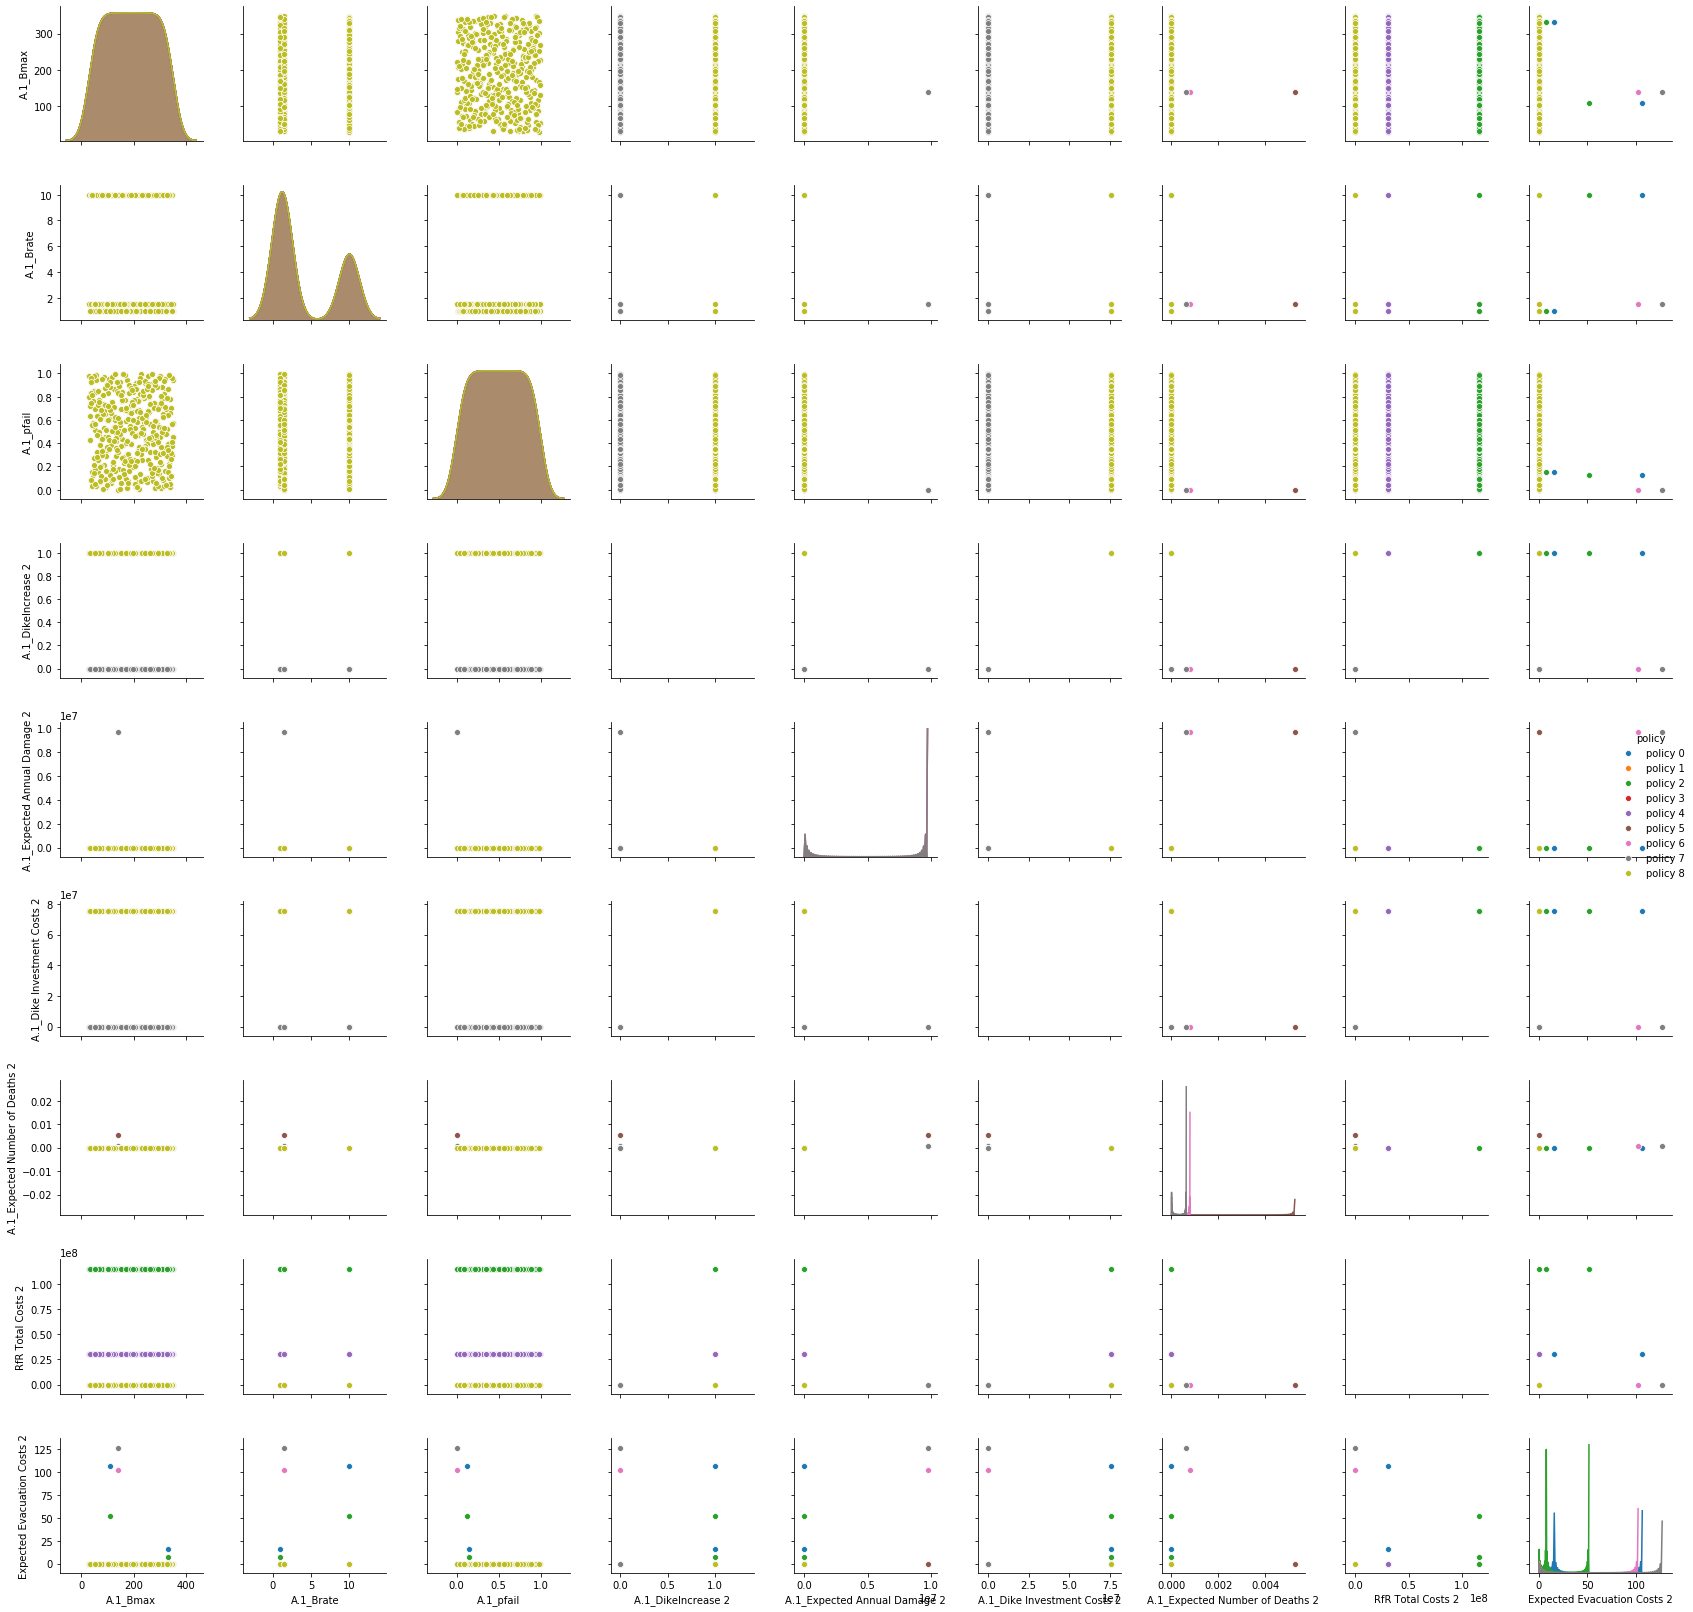

<function visualization_functions.pairplot_maker(results, location, n=3)>

In [12]:
# Takes more time to load than other visualizations
interact(pairplot_maker, results=fixed(results),
         n=[1, 2, 3], location=["A.1", "A.2", "A.3", "A.4", "A.5"])


The pairplot of A.1 and A.2 in timestep 1 show the policies color coded as well. The relationship of deaths and damages with pfail in this case has changed, the range of pfail in which damages and deaths occur is now lower. 

### 2.4 Boxplots across policies

Caution when looking at the plots, because the legend is not fixed! 

In [13]:
aggregate_outcomes(results, "Dike Investment Costs")
aggregate_outcomes(results, "RfR Total Costs")
aggregate_outcomes(results, "Expected Evacuation Costs")
results["Total Investment Costs"] = results.iloc[:, -3:].sum(axis=1)


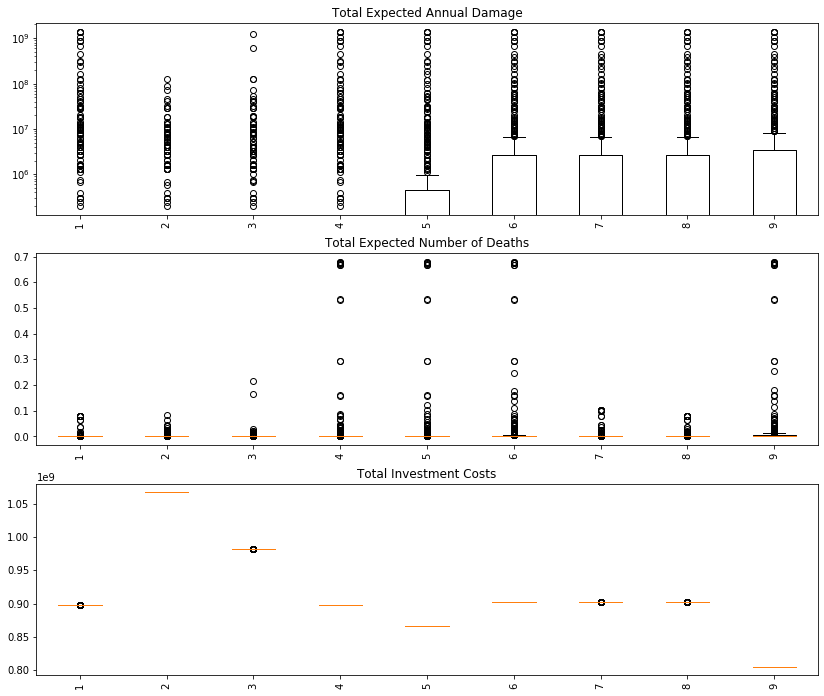

In [14]:
total_outcomes = ["Total Expected Annual Damage",
                  "Total Expected Number of Deaths", "Total Investment Costs"]

boxplot_maker(results, total_outcomes)


Compared to the open exploration of the 75 policies, the mean and the interquartile range perform better than most policies in damages. The outliers in deaths of policy 1, 2, 7, and 8 do not go above 0.1 even, however outliers in 4, 5, 6, and 9 are relatively high - even being higher than the ranges in the 75 policies. 

The policies however are optimized for the worst ranges in A.1 and A.3 pfails, while this is across the full uncertainty space. It is noticable that policies 1, 2, and 3 perform good in deaths and damages. 

### 2.5 Scatter plots

#### 2.5.1 Expected Number of Deaths

Plot Expected Number of Deaths(Scatterplot)
This is timestep 0


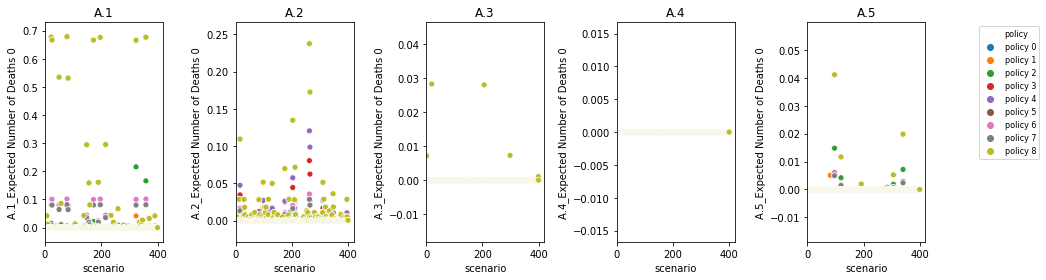

This is timestep 1


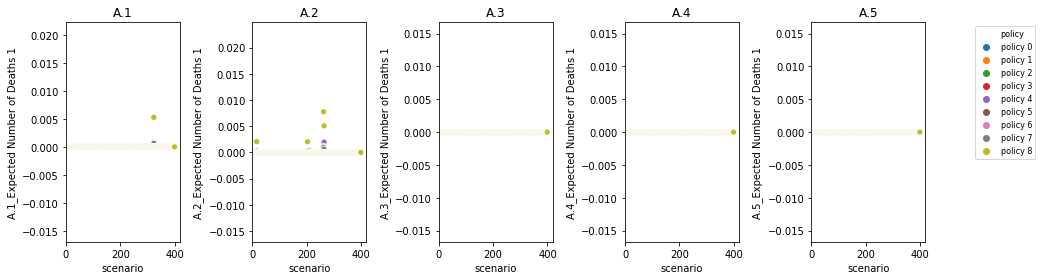

This is timestep 2


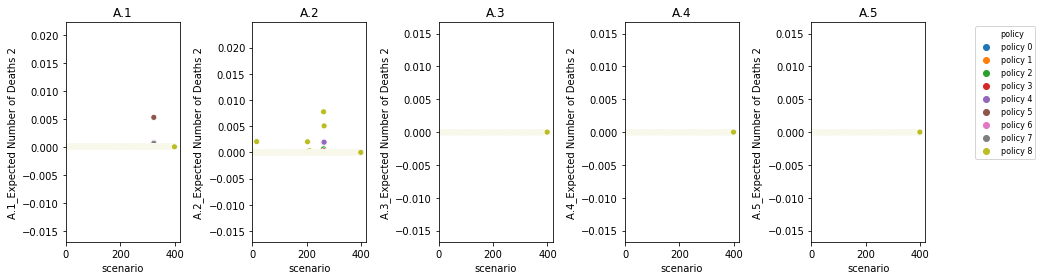

In [15]:
scatter_maker(results, "Expected Number of Deaths")


#### 2.5.2 Expected Annual Damage

Plot Expected Annual Damage(Scatterplot)
This is timestep 0


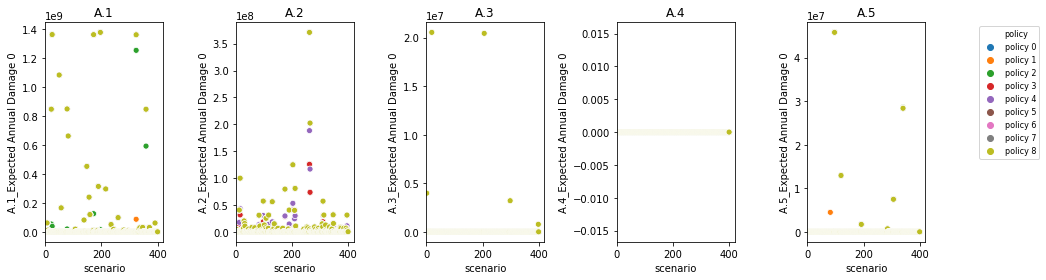

This is timestep 1


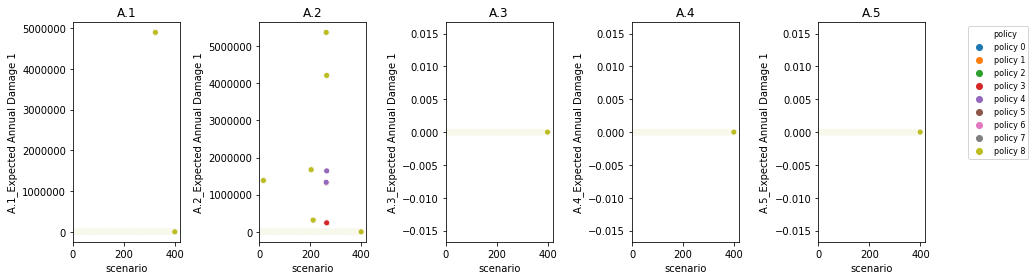

This is timestep 2


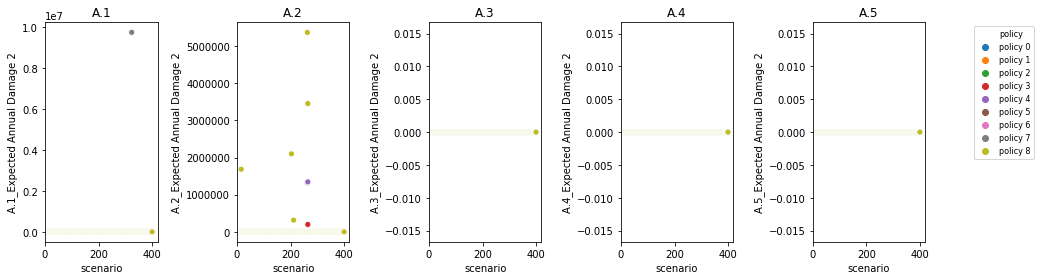

In [16]:
scatter_maker(results, "Expected Annual Damage")


These scatterplots show several important implications for the policies. It most commonly occurs in A.1 and A.2, however A.3 and A.5 are affected as well in the first time step. Another mention is that A.2 is affected in all time steps. When reviewing it is clear that policy 8 is not as robust as the other policies, due to the high number of scenarios in which the policy doesn't mitigate the damages and deaths. Other policies have outliers in specific locations, however it is not as systematic as policy 8. It is important to be mindful of these disadvantages as well for the final policy set. It is interesting to note that most outliers happen in A.1, while MORO has already taken the scenario space in which A.1pfail is low. 

### 2.6 Trade-offs

A parallel coordinates plot is created to visualize any apparent trade-offs in the created policies. 

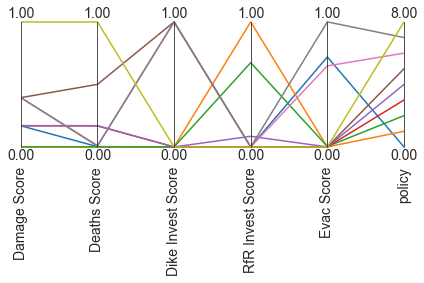

,Damage Score,Deaths Score,Dike Invest Score,RfR Invest Score,Evac Score,policy
0,0.169045,0.002302,0.000000e+00,0.001266,0.719602,0
1,0.000000,0.000030,0.000000e+00,1.000000,0.000000,1
2,0.000579,0.000000,0.000000e+00,0.674003,0.003484,2
3,0.169045,0.168033,2.167261e-07,0.001266,0.000000,3
4,0.170442,0.169976,1.118503e-07,0.084964,0.000000,4
5,0.394087,0.500243,1.000000e+00,0.000000,0.000000,5
6,0.394087,0.011139,1.000000e+00,0.000000,0.647903,6
7,0.394087,0.007086,1.000000e+00,0.000000,1.000000,7
8,1.000000,1.000000,2.114056e-07,0.000000,0.000000,8


In [17]:
data = results_MORO.iloc[:, -5:]
data_norm = (data - data.min()) / (data.max() - data.min())

# Added the policy column as it helps as a 'legend'
data_norm["policy"] = data.index
limits = parcoords.get_limits(data_norm)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data_norm)
plt.show()
data_norm


In [18]:
# Check one of the policies
# results_MORO.iloc[0, :-5]


The policies will also be visualized for a quick inspection.

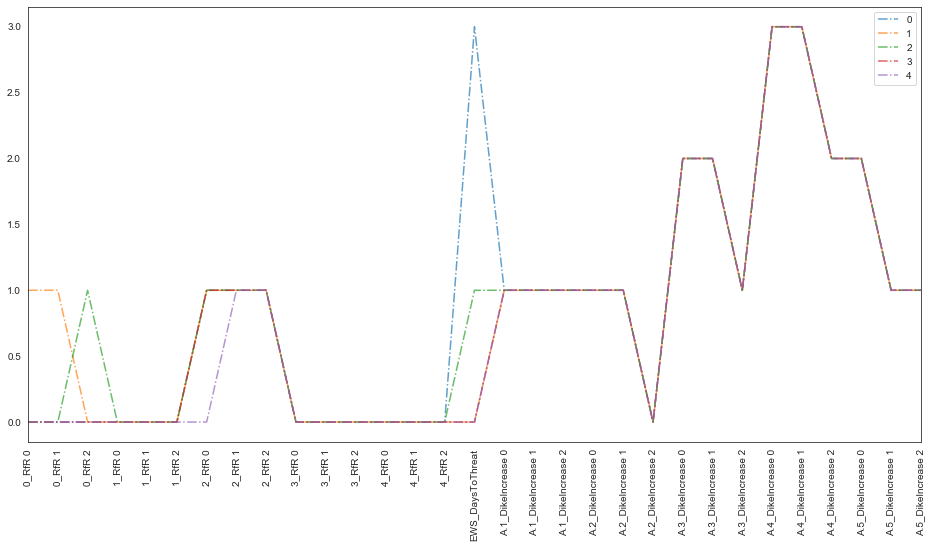

In [19]:
for i in results_MORO.index[:5]:
    results_MORO.iloc[i, :-5].plot('line', linestyle = '-.', alpha = 0.7)

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.xticks(np.arange(31), results_MORO.iloc[i, :-5].keys(), rotation=90)
plt.legend()
plt.show()

An inspection shows that policies from 5 onwards Room for the River does not include any Room for the River policies. These will not be taken into consideration as it does not help the biodiversity and nature areas in the IJsseldelta areas. Furthermore, in 2.4 it was clear that they have a relatively high interquartile range in damages. The downside to this decision is that all the low cost policies are disregarded. 

The RfR policies show that RfR exclusively is not the best, it should be in combination with other measures such as an evacuation or dike heightening. The policies give high importance to the locations A.1 and A.3 to implement Room for the River. Dike heightening is implemented in every location and timestep except for A.2 last timestep, however the height increases are small (< 3 decimeters), although the dike increases are accumulative on a location the highest accumulative increase is 0.8 meters. All the policies are similar in the dike heights. 

## 3. Scenario Discovery

The scenario discovery here is focused to find the scenarios in which the policies do not perform optimally. While earlier results showed that policy 8 is the least robust in certain locations, there were also scenarios in which the RfR policies (policy0-4) incurred damages. The scenario discovery will only be run on the RfR policies. 

In [20]:
results_rfr = results.iloc[:2000, :]


### 3.1 General Outcomes

Total Expected Number of Deaths First quartile (0.25): 0.0
Total Expected Number of Deaths Last quartile (0.75): 0.0
Total Expected Number of Deaths Mean: 0.009074881381378998
Total Expected Annual Damage First quartile (0.25): 0.0
Total Expected Annual Damage Last quartile (0.75): 0.0
Total Expected Annual Damage Mean: 20770881.5911625


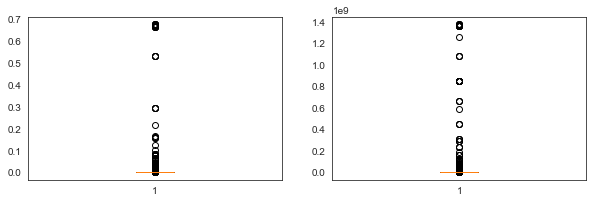

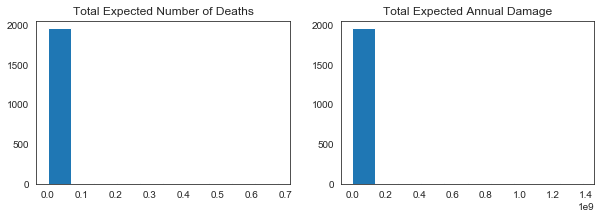

In [21]:
boxplot_histogram_maker(results_rfr)


The boxplot histogram maker shows that the percentiles are in annual damages and deaths are both 0. Further checks show that the 99th percentile is still 0. A study of the total aggregated outcomes would not be interesting. The scatter plots also showed that specific locations were hindered. 

These specific outcomes will be reviewed to see if they are interesting.

### 3.2 Further investigation on specific locations

Further discovery of location A1 and A2  as the scatter plots and histograms showed that the policies are not robust in these locations. The specific outcomes of these locations will be examined. The interested cases are anything that is not 0. 

In [22]:
# Find the percentiles
print("A.1 Deaths: " +
      str((results_rfr["A.1_Expected Number of Deaths 0"] > 0).value_counts()[1] / 2000))
print("A.1 Damages: " +
      str((results_rfr["A.1_Expected Annual Damage 0"] > 0).value_counts()[1] / 2000))
print("A.2 Deaths: " +
      str((results_rfr["A.2_Expected Number of Deaths 0"] > 0).value_counts()[1] / 2000))
print("A.2 Damages: " +
      str((results_rfr["A.2_Expected Annual Damage 0"] > 0).value_counts()[1] / 2000))


# print((results_rfr["A.1_Expected Number of Deaths 0"] > 0).value_counts())
# print((results_rfr["A.1_Expected Annual Damage 0"] > 0).value_counts())
# print((results_rfr["A.2_Expected Number of Deaths 0"] > 0).value_counts())
# print((results_rfr["A.2_Expected Annual Damage 0"] > 0).value_counts())


A.1 Deaths: 0.069
A.1 Damages: 0.069
A.2 Deaths: 0.1325
A.2 Damages: 0.1325


In [23]:
loc_columns = ["A.1_Expected Number of Deaths 0", "A.1_Expected Annual Damage 0", "A.2_Expected Annual Damage 0",
               "A.2_Expected Number of Deaths 0"]

x = results_rfr.iloc[:, :19]  # Only take the uncertainties
y = results_rfr[loc_columns]
y["A.1_Expected Number of Deaths 0"] = y["A.1_Expected Number of Deaths 0"] > np.percentile(
    y["A.1_Expected Number of Deaths 0"], 0.93)
y["A.1_Expected Annual Damage 0"] = y["A.1_Expected Annual Damage 0"] > np.percentile(
    y["A.1_Expected Annual Damage 0"], 0.93)
y["A.2_Expected Number of Deaths 0"] = y["A.2_Expected Number of Deaths 0"] > np.percentile(
    y["A.2_Expected Number of Deaths 0"], 0.87)
y["A.2_Expected Annual Damage 0"] = y["A.2_Expected Annual Damage 0"] > np.percentile(
    y["A.2_Expected Annual Damage 0"], 0.87)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

The algorithm behind feature scoring is [extra trees](https://link.springer.com/article/10.1007/s10994-006-6226-1) which is applicable to regression as well as classification problems. We have changed it here into a classification problem as we are only interested in the points which have a higher damage / death outcome than 0. This shows that the uncertainties A.1pfail and A.2pfail are most critical in the number of deaths and damages. For further policy optimization it might be interesting to specify these uncertainty ranges more in MORO analysis to find a robust policy in this space. 

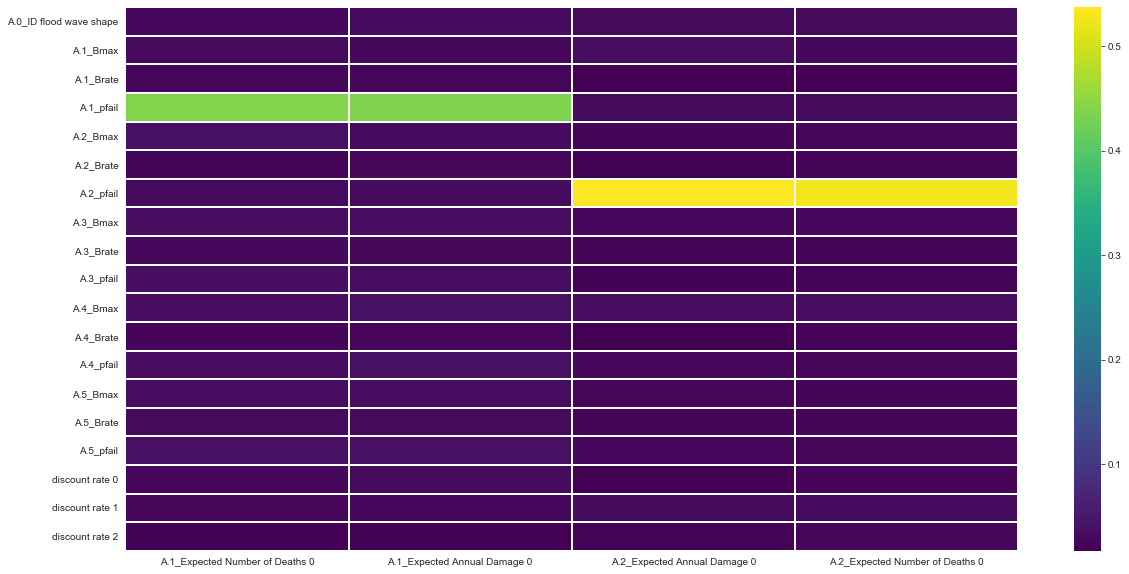

In [24]:
fs = feature_scoring.get_feature_scores_all(
    x, y, mode=RuleInductionType.CLASSIFICATION)
fig = plt.subplots(figsize=(20, 10))

sns.heatmap(fs, cmap='viridis', linewidths=1)
plt.show()
